In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import numpy as np  
from torchvision.io import read_image
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import random
from scipy.io import loadmat
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

dtype = torch.float32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/Shareddrives/SAMM and CK/SAMM/SAMM.zip"
!unzip "/content/drive/MyDrive/SAMM_IEEETAC_Movements.zip"

**Data Cleaning**

In [ ]:
#SAMM data file
df=pd.read_excel("/content/drive/MyDrive/SAMM_Micro_FACS_Codes_v2_fixed_v2.xlsx",header=13)
df

,Subject,Filename,Inducement Code,Onset Frame,Apex Frame,Offset Frame,Duration,Micro,Action Units,Estimated Emotion,Objective Classes,Notes
0,6,006_1_2,1,5562,5588,5632,71,Micro - 1/2,4+7,Anger,3,Half blink
1,6,006_1_3,1,3912,3948,3988,77,Micro - 1/2,4,Anger,3,While blinking
2,6,006_1_4,1,2324,2368,2403,80,Micro - 1/2,4+7,Anger,3,NaN
3,6,006_1_5,1,5343,5388,5424,82,Micro - 1/2,4+7,Anger,3,NaN
4,6,006_1_6,1,7160,7197,7259,100,Micro - 1/2,4+7+43,Anger,7,Double AU4
...,...,...,...,...,...,...,...,...,...,...,...,...
154,35,035_7_2,7,823,855,918,96,Micro - 1/2,R14A or 17A or 24A,Contempt,7,NaN
155,36,036_7_3,7,2264,2339,2363,100,Micro - 1/2,R10A+25+26,Disgust,4,Stays with 25+26 and eye movement
156,37,037_3_1,3,3306,3342,3382,77,Micro - 1/2,24,Other,7,NaN
157,37,037_3_2,3,3196,3214,3295,100,Micro - 1/2,T23,Anger,3,NaN


In [ ]:
#Choose only 5 classes
option=['Anger','Happiness','Surprise','Contempt','Other']
check=df[df['Estimated Emotion'].isin(option)].reset_index()

In [ ]:
#Find index of Apex frame
start=check['Apex Frame']-check['Onset Frame']
start
fp=list(check['Filename'])

In [ ]:
#Choice 1 - Split data to 5 folds
exp = {"Other":0,"Anger":1,"Contempt":2,"Happiness":3,"Surprise":4}
from sklearn.model_selection import StratifiedGroupKFold
df_5=check
k = 5
X = np.ones((len(df_5), 2))
y = np.zeros(len(df_5))
groups = np.zeros(len(df_5))

for idx in range(len(df_5)):
    y[idx] = exp[df_5.iloc[idx]['Estimated Emotion']]
    groups[idx] = df_5.iloc[idx]['Subject']    

cv = StratifiedGroupKFold(n_splits=k)

In [ ]:
#Choice 2 - Split data to 27 sets
from sklearn.model_selection import LeaveOneGroupOut
df_5=check
k = 29
X = np.ones((len(df_5), 2))
y = np.zeros(len(df_5))
groups = np.zeros(len(df_5))

for idx in range(len(df_5)):
    y[idx] = exp[df_5.iloc[idx]['Estimated Emotion']]
    groups[idx] = df_5.iloc[idx]['Subject']    

cv = LeaveOneGroupOut()

In [ ]:
#Find index of each set
folds = {'train':[], 'val':[]}
for train_idx, val_idx in cv.split(X, y, groups=groups):
    folds['train'].append(train_idx)
    folds['val'].append(val_idx)  

In [ ]:
len(folds['train'])

5

In [ ]:
#Get optical flow and original frame input
def get_flow_img(img_0, img_1):
    h, w = img_0.shape
    v, u = optical_flow_tvl1(img_0, img_1)

    # normalize u and v to approximately [0,1]
    min_uv = np.min([np.min(u), np.min(v)])
    max_uv = np.max([np.max(u), np.max(v)])
    u = (u-min_uv) / (1e-6 + max_uv - min_uv)
    v = (v-min_uv) / (1e-6 + max_uv-min_uv)

    # stack 3 channels
    flow_img = np.zeros((h, w, 3))
    flow_img[..., 0] = u
    flow_img[..., 1] = v
    flow_img[..., 2] = img_1/255 # normalize to [0,1]

    return flow_img

#----------------------------------------------
import torch
import torchvision.transforms as transforms
# transform to apply when load dataset
# convert [0,1] to [-1,1]
# convert from numpy to tensor
# resize to (224, 224)
transform_flow_img = T.Compose([
          T.Lambda(
            lambda x: torch.tensor(np.transpose(x*2 - 1, (2,0,1)), dtype=torch.float32)
          ),
          T.Resize((224, 224))
    ])

In [ ]:
#Get Optical flow pic
tl=[]
k=0
for i in range(136):
  j=fp[i]
  mat =loadmat("/content/SAMM_IEEETAC_Movements/"+j)
  mat_imgs = np.transpose(mat["tempImg"], (2,0,1))
  a=start[i]
  img_0=mat_imgs[0]
  fimg=get_flow_img(img_0, mat_imgs[a])
  tl.append(fimg)
tl[0]

In [ ]:
#Get Diff Apex-Onset pic
tl=[]
k=0
for i in range(136):
  j=fp[i]
  mat =loadmat("/content/SAMM_IEEETAC_Movements/"+j)
  mat_imgs = np.transpose(mat["tempImg"], (2,0,1))
  a=start[i]
  img_0=mat_imgs[0]
  tl.append(mat_imgs[a]-img_0)

In [ ]:
#Get Apex frame pic
tl=[]
k=0
for i in range(136):
  j=fp[i]
  mat =loadmat("/content/SAMM_IEEETAC_Movements/"+j)
  mat_imgs = np.transpose(mat["tempImg"], (2,0,1))
  a=start[i]
  img_0=mat_imgs[0]
  tl.append(mat_imgs[a])

In [ ]:
#Save for next time
np.save("/content/drive/MyDrive/testlist_fixed_3chn",tl)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
#Load Optical flow pic
tl=np.load("/content/drive/MyDrive/testlist_fixed.npy",allow_pickle=True)

In [ ]:
#Load Optical flow + Apex frame pic
tl=np.load("/content/drive/MyDrive/testlist_fixed_3chn.npy",allow_pickle=True)

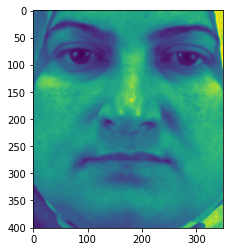

In [ ]:
#Try visualize tl
plt.imshow(tl[130])

In [ ]:
#Choose one k=5 or k=27
k=27
k=5
testlist=[]
vallist=[]
for fold_idx in range(k):
  tt=[]
  vt=[]
  train_idx = folds['train'][fold_idx]
  val_idx = folds['val'][fold_idx]
  for i in train_idx:
    tt.append(tl[i])
  for i in val_idx:
    vt.append(tl[i])
  testlist.append(tt)
  vallist.append(vt)

In [ ]:
len(testlist)

0

In [ ]:
len(tl)

136

In [ ]:
val_idx

In [ ]:
#Ten videos of baseline
kkk=["007_5_3","007_6_1","015_5_2","015_5_3","019_3_2","019_4_1","035_1_1","035_4_1","035_5_1","035_7_2"]
a=0
d=[]
for i in check["Filename"]:
  if i in kkk:d.append(a)
  a+=1
d
tenvid=[]
vt=[]
val_idx=d
for i in val_idx:
  vt.append(tl[i])
tenvid=vt

In [ ]:
len(tenvid)

10

In [ ]:
#Make labels doc
df=check
#exp = {0:"Other",1:"Anger",2:"Contempt",3:"Disgust",4:"Fear",5:"Happiness",6:"Sadness",7:"Surprise"}
exp = {"Other":0,"Anger":1,"Contempt":2,"Happiness":3,"Surprise":4}
b=[]
name=[]
folder=list(df['Filename'])
for file in df['Filename']:
    for root, dirs, filename in os.walk("/content/SAMM/"+f'{file[:3]}/{file}'):
      for abc in filename:
        b.append("/content/SAMM/"+abc[:3]+"/"+file+"/"+abc)
aa=df[['Filename','Estimated Emotion']]
aa.loc[0][1]
#aa.to_csv('/content/train.csv')


Data Loader

In [ ]:
#Create CustomDataset
class CustomImageDataset(Dataset):
    def __init__(self,labellist, img_dir, transform, target_transform=None):
        self.img_labels = labellist
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_dir[idx]
        label = aa.loc[self.img_labels[idx]][1]
        if self.transform:
            im = image
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        label=exp[label]
        return image, label

Visualize data

In [ ]:
#Try 1 sample
from torchvision.transforms.transforms import ToTensor
from PIL import Image

#Tune transfrom for each input type
transform = T.Compose([
                       #T.Lambda(lambda x: torch.tensor(np.transpose(x*2 - 1, (2,0,1)), dtype=torch.float32)),
                       #T.Resize((224, 224))
                       T.Lambda(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))),
                       T.Lambda(lambda x: np.array(Image.fromarray(x*255).convert('RGB'))),
                       #T.Lambda(lambda x: 1-x),
                       T.ToPILImage(),
                       T.Resize((224,224)),
                       #T.CenterCrop(224),
                       #T.RandomHorizontalFlip(),
                       T.ToTensor(),
                       T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                       #T.ToPILImage(),
                       ])  

train = CustomImageDataset(list(folds['train'][2]),testlist[2],transform)
val = CustomImageDataset(list(folds['val'][2]),vallist[2],transform)

dataloaders={train: torch.utils.data.DataLoader(train, batch_size=40,
                                              shuffle=True, num_workers=2)
                ,val:torch.utils.data.DataLoader(val, batch_size=40,
                                              shuffle=False, num_workers=2)}
dataset_sizes={train: len(train),val : len(val)}

loss_history = []
validation_acc = []
training_acc = []

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


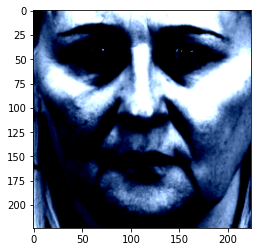

In [ ]:
#Visualize when loaded with Dataloader
%matplotlib inline              
i=0
import matplotlib.pyplot as plt
import random                   #For selecting random element from list
random_idx = random.sample(range(0,111),1)[0]
dataiter = iter(dataloaders[train])   #The iter() function in python represents the iterator similar to c++ iterators
images,labels = dataiter.next() #The next() method retrieves the object 
expression = {0:"Other",1:"Anger",2:"Contempt",3:"Happiness",4:"Surprise"} #Create a dictionary for mapping accordingly
#random_idx = random.sample(range(0,0),1)[0]     #Selects a random single number from 0-64
#print("Target label: ",expression[int(labels.numpy())])  #Converting it to numpy from tensor to fetch the label
random_idx = random.sample(range(0,1),1)[0]     #Selects a random single number from 0-64
#print("Target label: ",expression[labels[random_idx].numpy()])  #Converting it to numpy from tensor to fetch the label
plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
print(labels[i])

Training

In [ ]:
#Visualize Loss
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/loss_visualize')
%tensorboard --logdir=runs

In [ ]:
classes = ['Other','Anger','Contempt','Happiness','Surprise']

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

'def plot_classes_preds(net, images, labels):\n\n    \n    preds, probs = images_to_probs(net, images)\n    # plot the images in the batch, along with predicted and true labels\n    fig = plt.figure(figsize=(12, 48))\n    for idx in np.arange(4):\n        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])\n        matplotlib_imshow(images[idx], one_channel=True)\n        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(\n            classes[preds[idx]],\n            probs[idx] * 100.0,\n            classes[labels[idx]]),\n                    color=("green" if preds[idx]==labels[idx].item() else "red"))\n    return fig'

In [ ]:
#Training 1 set
import time
import copy
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
ba=[]
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    i=0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train, val]:
            if phase == train:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            
            i=0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if phase == train:p='train'
                else:p='val'
                # ...log the running loss
                writer.add_scalar(f'{p}_loss',
                running_loss / 1000,
                epoch * len(dataloaders[phase]) + i)

                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                #writer.add_figure('predictions vs. actuals',
                #plot_classes_preds(model, inputs, labels),
                #global_step=epoch * len(dataloaders[phase]) + i

            if phase == train:
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == train:p='train'
            else:p='val'
            print(f'{p} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Models

In [ ]:
#Find weight in each set
aadd=[]
for fold_idx in range(k):
    aad=[]
    train_idx = folds['train'][fold_idx]
    val_idx = folds['val'][fold_idx]
    emo_count_train = df_5.iloc[train_idx]['Estimated Emotion'].value_counts()
    emo_count_val = df_5.iloc[val_idx]['Estimated Emotion'].value_counts()

    
    for emo in exp.keys():
        emo_train = 0 if emo not in emo_count_train else emo_count_train[emo]
        emo_val = 0 if emo not in emo_count_val else emo_count_val[emo]
        aad.append(emo_train)
    aadd.append(aad)

In [ ]:
aadd[0]

[26, 50, 12, 26, 13]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
w=[]
for i in aadd:
  w.append((sum(i)/torch.tensor(i)).to(device))
w

[tensor([ 4.8846,  2.5400, 10.5833,  4.8846,  9.7692], device='cuda:0'),
 tensor([ 5.2917,  2.2281, 10.5833,  6.0476,  9.7692], device='cuda:0'),
 tensor([ 5.1154,  2.4182, 11.0833,  5.1154,  9.5000], device='cuda:0'),
 tensor([ 5.0769,  2.4906, 11.0000,  5.0769,  8.8000], device='cuda:0'),
 tensor([ 4.6538,  2.3269, 13.4444,  6.3684,  8.0667], device='cuda:0'),
 tensor([ 5.1923,  2.3684, 11.2500,  5.1923,  9.6429], device='cuda:0'),
 tensor([ 5.0000,  2.5490, 10.8333,  5.0000,  8.6667], device='cuda:0'),
 tensor([ 5.0400,  2.2105, 11.4545,  6.6316,  9.0000], device='cuda:0'),
 tensor([ 5.1538,  2.3509, 12.1818,  5.1538,  9.5714], device='cuda:0'),
 tensor([ 5.0385,  2.3818, 10.9167,  5.2400, 10.0769], device='cuda:0'),
 tensor([ 5.4167,  2.3214, 13.0000,  5.0000,  9.2857], device='cuda:0'),
 tensor([ 5.3600,  2.3509, 11.1667,  5.1538,  9.5714], device='cuda:0'),
 tensor([ 5.5417,  2.3333, 11.0833,  5.3200,  8.8667], device='cuda:0'),
 tensor([ 6.0476,  2.2679, 11.5455,  5.2917,  8.466

In [ ]:
#Try training 1 set

model_ft = models.resnet18(pretrained=False)
pretrained_weight_nc = 12666
model_ft.fc = nn.Linear(model_ft.fc.in_features, pretrained_weight_nc) 

model_ft.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_pretrained_on_msceleb.pth"))
model_ft.fc = nn.Linear(model_ft.fc.in_features, 5)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss(weight=w[2])

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00075, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 2.3939 Acc: 0.2804
val Loss: 1.7690 Acc: 0.3448

Epoch 1/19
----------
train Loss: 1.5650 Acc: 0.3645
val Loss: 1.8775 Acc: 0.2069

Epoch 2/19
----------
train Loss: 0.9210 Acc: 0.5701
val Loss: 1.8844 Acc: 0.3103

Epoch 3/19
----------
train Loss: 0.3466 Acc: 0.9065
val Loss: 1.9229 Acc: 0.3448

Epoch 4/19
----------
train Loss: 0.1709 Acc: 0.9907
val Loss: 2.0355 Acc: 0.3793

Epoch 5/19
----------
train Loss: 0.1180 Acc: 1.0000
val Loss: 2.1576 Acc: 0.3793

Epoch 6/19
----------
train Loss: 0.0764 Acc: 1.0000
val Loss: 2.1844 Acc: 0.4138

Epoch 7/19
----------
train Loss: 0.0438 Acc: 1.0000
val Loss: 2.1968 Acc: 0.4483

Epoch 8/19
----------
train Loss: 0.0503 Acc: 1.0000
val Loss: 2.2296 Acc: 0.3793

Epoch 9/19
----------
train Loss: 0.0425 Acc: 1.0000
val Loss: 2.2539 Acc: 0.3103

Epoch 10/19
----------
train Loss: 0.0464 Acc: 1.0000
val Loss: 2.2858 Acc: 0.3103

Epoch 11/19
----------
train Loss: 0.0367 Acc: 1.0000
val Loss: 2.3043 Acc: 0.3448

Ep

In [ ]:
#Train LOSO 27 sets
tempval=[]
ba=[]
for i in range(k):
  print("Fold "+str(i))
  transform = T.Compose([
                       T.Lambda(lambda x: torch.tensor(np.transpose(x*2 - 1, (2,0,1)), dtype=torch.float32)),
                       #T.Resize((224, 224))
                       #T.Lambda(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))),
                       #T.Lambda(lambda x: np.array(Image.fromarray(x*255).convert('RGB'))),
                       #T.Lambda(lambda x: 1-x),
                       T.ToPILImage(),
                       T.Resize((224,224)),
                       #T.CenterCrop(224),
                       #T.RandomHorizontalFlip(),
                       T.ToTensor(),
                       #T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
                       #T.ToPILImage(),
                       ]) 
  train = CustomImageDataset(list(folds['train'][i]),testlist[i],transform)
  val = CustomImageDataset(list(folds['val'][i]),vallist[i],transform)
  tempval.append(DataLoader(val,batch_size=40,shuffle=False))
  dataloaders = {train: torch.utils.data.DataLoader(train, batch_size=40,
                                              shuffle=True, num_workers=2)
                ,val:torch.utils.data.DataLoader(val, batch_size=40,
                                              shuffle=False, num_workers=2)
                }
  dataset_sizes = {train: len(train),val : len(val)}

  loss_history = []
  validation_acc = []
  training_acc = []

  model_ft = models.resnet18(pretrained=False)
  pretrained_weight_nc = 12666
  model_ft.fc = nn.Linear(model_ft.fc.in_features, pretrained_weight_nc) 

  model_ft.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_pretrained_on_msceleb.pth"))
  model_ft.fc = nn.Linear(model_ft.fc.in_features, 5)


  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss(weight=w[i])

  # Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.00075, momentum=0.9)

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=20)
  model_scripted = torch.jit.script(model_ft) # Export to TorchScript
  model_scripted.save('/content/drive/MyDrive/Model save/modelrgb2'+str(i)+'.pt')

Fold 0
Epoch 0/19
----------
train Loss: 2.1076 Acc: 0.1496
val Loss: 1.9630 Acc: 0.0000

Epoch 1/19
----------
train Loss: 1.2976 Acc: 0.4882
val Loss: 2.1546 Acc: 0.1111

Epoch 2/19
----------
train Loss: 0.6072 Acc: 0.8346
val Loss: 2.0842 Acc: 0.5556

Epoch 3/19
----------
train Loss: 0.3037 Acc: 0.9213
val Loss: 2.2897 Acc: 0.4444

Epoch 4/19
----------
train Loss: 0.2688 Acc: 0.9449
val Loss: 2.5941 Acc: 0.5556

Epoch 5/19
----------
train Loss: 0.1360 Acc: 0.9764
val Loss: 2.9966 Acc: 0.5556

Epoch 6/19
----------
train Loss: 0.0607 Acc: 1.0000
val Loss: 3.3963 Acc: 0.6667

Epoch 7/19
----------
train Loss: 0.0616 Acc: 1.0000
val Loss: 3.4598 Acc: 0.6667

Epoch 8/19
----------
train Loss: 0.0931 Acc: 0.9764
val Loss: 3.4451 Acc: 0.6667

Epoch 9/19
----------
train Loss: 0.0458 Acc: 1.0000
val Loss: 3.3265 Acc: 0.6667

Epoch 10/19
----------
train Loss: 0.0427 Acc: 1.0000
val Loss: 3.2764 Acc: 0.6667

Epoch 11/19
----------
train Loss: 0.0314 Acc: 1.0000
val Loss: 3.2458 Acc: 0.5

In [ ]:
#Load saved best model
model_ft = torch.jit.load('/content/drive/MyDrive/model_2_60acc.pt',map_location=torch.device('cpu'))

[1, 2, 2, 1, 3, 3, 1, 1, 0, 2]
[4, 3, 2, 4, 0, 3, 1, 1, 0, 2]


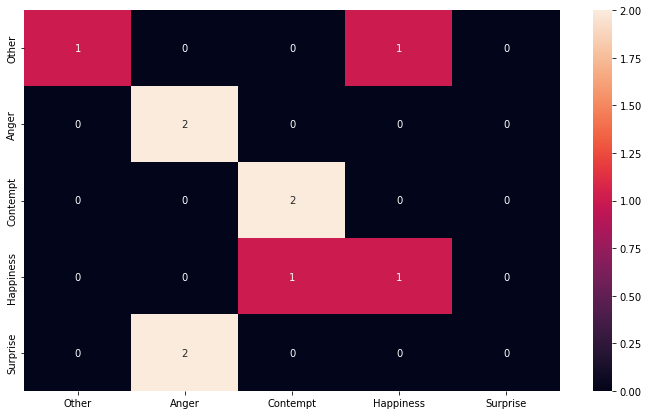

In [ ]:
#Visualize Baseline set
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

kkk=["007_5_3","007_6_1","015_5_2","015_5_3","019_3_2","019_4_1","035_1_1","035_4_1","035_5_1","035_7_2"]
a=0
d=[]
for i in df["Filename"]:
  if i in kkk:d.append(a)
  a+=1
d
tenvid=[]
vt=[]
val_idx=d
for i in val_idx:
  vt.append(tl[i])
tenvid=vt
eiei = CustomImageDataset(d,tenvid,transform)
testl= DataLoader(eiei,batch_size=32,shuffle=False)



# iterate over test data
y_pred = []
y_true = []
for inputs, labels in testl:
    model_ft.eval()
    with torch.no_grad():
        output = model_ft(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
          
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
classes = ['Other','Anger','Contempt','Happiness','Surprise']
  # Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                      columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
print(y_pred)
print(y_true)
#plt.savefig("/content/drive/MyDrive/Model save/Confusion Matrix/Fold "+str(i+1))

In [ ]:
#F1 score
from sklearn.metrics import f1_score
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloaders[val]:
  with torch.no_grad():
        output = model_ft(inputs.cuda()) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes

#classes = ["Other","Anger","Contempt","Happiness","Surprise"]
classes=[0,1,2,3,4]
# Build confusion matrix
f1 = f1_score(y_true, y_pred,labels=classes,average='weighted')
print("F1 Weighted\t",f1_score(y_true, y_pred,labels=classes,average='weighted'))
print("F1 Micro\t",f1_score(y_true, y_pred,labels=classes,average='micro'))
print("F1 Macro\t",f1_score(y_true, y_pred,labels=classes,average='macro'))

F1 Weighted	 0.38238970700326236
F1 Micro	 0.4482758620689655
F1 Macro	 0.3497789566755084


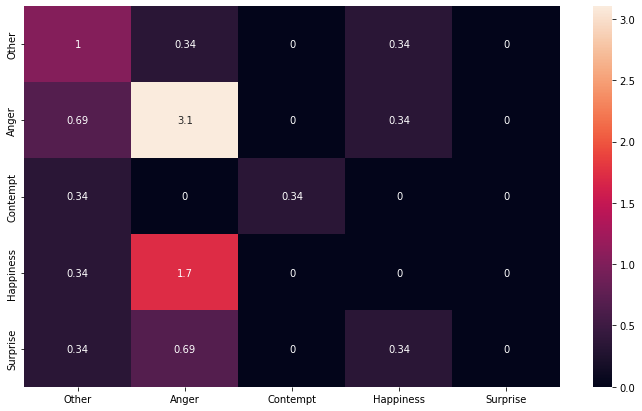

In [ ]:
#Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd



# iterate over test data
y_pred = []
y_true = []
for inputs, labels in dataloaders[val]:
    model_ft.eval()
    with torch.no_grad():
        output = model_ft(inputs.cuda()) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
          
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
classes = ['Other','Anger','Contempt','Happiness','Surprise']
  # Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                      columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
#plt.savefig("/content/drive/MyDrive/Model save/Confusion Matrix/Fold "+str(i+1))

In [ ]:
#Save model
model_scripted = torch.jit.script(model_ft) # Export to TorchScript
model_scripted.save('/content/drive/MyDrive/modelabc.pt')

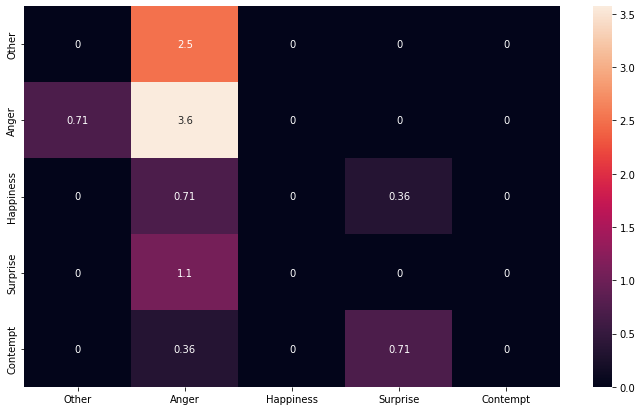

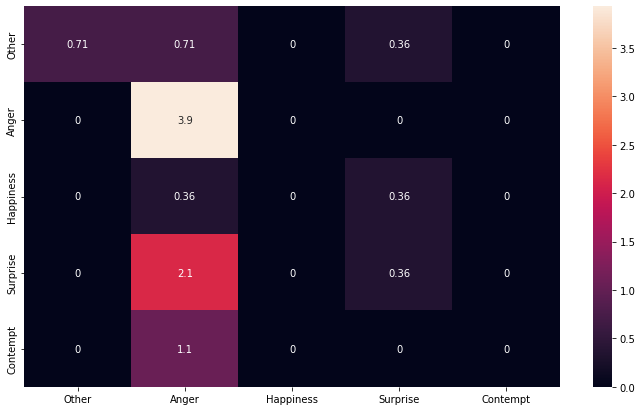

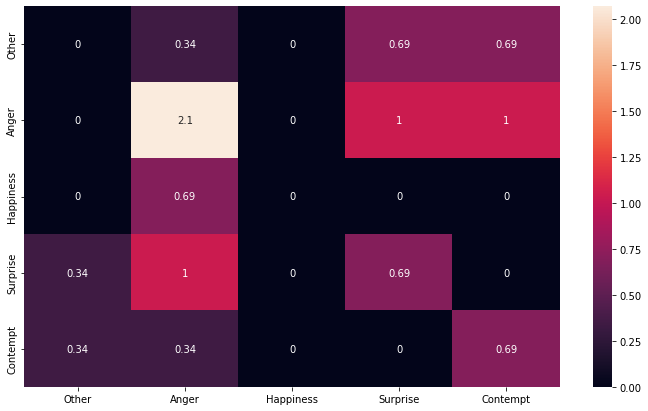

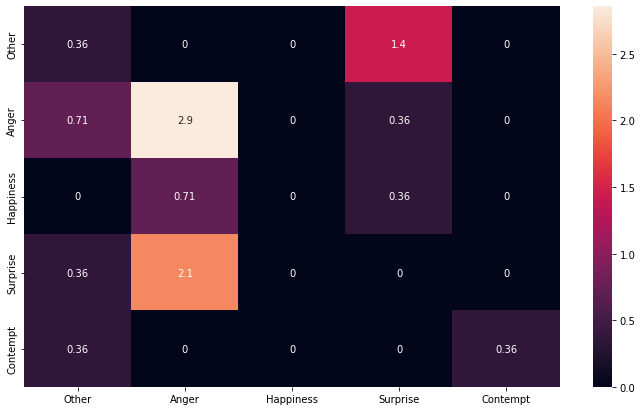

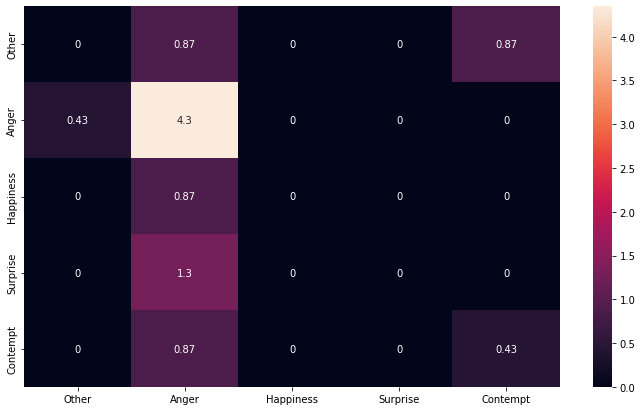

In [ ]:
#Try visualize confusion matrix from 5-folds cross validation
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd



# iterate over test data
for i in range(k):
  y_pred = []
  y_true = []
  for inputs, labels in tempval[i]:
      model_ft = torch.jit.load('/content/drive/MyDrive/Model save/model'+str(i)+'.pt')
      model_ft.eval()
      with torch.no_grad():
          output = model_ft(inputs.cuda()) # Feed Network
          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth
  classes = ['Other','Anger','Contempt','Happiness','Surprise']
  # Build confusion matrix
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                      columns = [i for i in classes])
  plt.figure(figsize = (12,7))
  sn.heatmap(df_cm, annot=True)
  plt.savefig("/content/drive/MyDrive/Model save/Confusion Matrix/Fold "+str(i+1))

In [ ]:
#Try visualize confusion matrix from LOSO
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sn
import pandas as pd

yp=[]
yt=[]
for i in range(k):
  y_pred = []
  y_true = []
  # iterate over test data
  for inputs, labels in tempval[i]:
      model_ft = torch.jit.load('/content/drive/MyDrive/Model save/model'+str(i)+'.pt')
      model_ft.eval()
      with torch.no_grad():
          output = model_ft(inputs.cuda()) # Feed Network
          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth
  yp.extend(y_pred)
  yt.extend(y_true)
classes=[0,1,2,3,4]
  # Build confusion matrix
#f1 = f1_score(yt, yp,labels=classes,average='weighted')
print("Fold "+str(i+1))
print("F1 Micro\t",f1_score(yt, yp,labels=classes,average='micro'))
print("F1 Macro\t",f1_score(yt, yp,labels=classes,average='macro'))
print("\n")
classes = ['Other','Anger','Contempt','Happiness','Surprise']
# Build confusion matrix
cf_matrix = confusion_matrix(yt, yp)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                      columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
#F1 score from LOSO and 5-folds
from sklearn.metrics import f1_score
import seaborn as sn
import pandas as pd
f = open("/content/drive/MyDrive/Model save/f1_score.txt", "w")
f = open("/content/drive/MyDrive/Model save/f1_score.txt", "a")
for i in range(k):
  y_pred = []
  y_true = []
  # iterate over test data
  for inputs, labels in tempval[i]:
      model_ft = torch.jit.load('/content/drive/MyDrive/Model save/model'+str(i)+'.pt')
      model_ft.eval()
      with torch.no_grad():
          output = model_ft(inputs.cuda()) # Feed Network
          output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
          y_pred.extend(output) # Save Prediction
          
          labels = labels.data.cpu().numpy()
          y_true.extend(labels) # Save Truth

  # constant for classes

  #classes = ["Other","Anger","Contempt","Happiness","Surprise"]
  classes=[0,1,2,3,4]
  # Build confusion matrix
  f1 = f1_score(y_true, y_pred,labels=classes,average='weighted')
  print("Fold "+str(i+1))
  print("F1 Micro\t",f1_score(y_true, y_pred,labels=classes,average='micro'))
  print("F1 Macro\t",f1_score(y_true, y_pred,labels=classes,average='macro'))
  print("\n")
  f.write("Fold "+str(i+1))
  f.write("\nF1 Micro\t"+str(f1_score(y_true, y_pred,labels=classes,average='micro')))
  f.write("\nF1 Macro\t"+str(f1_score(y_true, y_pred,labels=classes,average='macro')))
  f.write("\n\n")
f.close()